In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from tools.utils import set_seed
import numpy as np

set_seed(1234)

2023-07-31 20:32:36.154776: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 20:32:36.342010: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 20:32:36.924568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset
Create and load dataset. Split dataset into train-validation-test with 0.8, 0.1, 0.1 percentages

In [2]:
dataset_name = DatasetName.RADIOML_2016
dataset_path = os.path.abspath(cur_dir + "/data/radioml_2016/RML2016.10a_dict.pkl")
radioml_ds = make_sigmod_ds(dataset_name)
radioml_ds.load(dataset_path)
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)

# Create Model
Create convolutional model

In [3]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName

# model that I used in the diploma
# cnn_v1_configuration = Convolution01xConfiguration(
#     input_shape=(128, 2),
#     n_classes=len(radioml_ds.get_modulations()),
#     output_channels=[32, 48, 64, 96, 128, 192],
#     kernel_sizes=[8, 8, 8, 8, 8, 8],
#     paddings=["same", "same", "same", "same", "same", "same"],
#     max_pool_sizes=[1, 1, 2, 1, 2, 1],
#     max_pool_strides=[1, 1, 2, 1, 2, 1],
#     avg_size=32,
#     dense_sizes=[],
# )
# model_dir = "cnn_test_results/" # dumped original model
# model_name = "cnn_1d_v012_radioml"

# Small model
cnn_v1_configuration = Convolution01xConfiguration(
    input_shape=(128, 2),
    n_classes=len(radioml_ds.get_modulations()),
    output_channels=[32, 48, 64, 96, 128, 192],
    kernel_sizes=[8, 8, 8, 8, 8, 8],
    paddings=["same", "same", "same", "same", "same", "same"],
    max_pool_sizes=[1, 1, 2, 1, 2, 1],
    max_pool_strides=[1, 1, 2, 1, 2, 1],
    avg_size=32,
    dense_sizes=[                                                                                                                                                                                                                                                                                                                                                           ],
)

model_dir = "small_cnn_test_results/"
model_name = "cnn_1d_v012_small_radioml"

model = make_sigmod_model(ModelName.CNN_1D_V012, cnn_v1_configuration)

# model.summary()

2023-07-31 20:36:29.311592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 20:36:29.390706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 20:36:29.390832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Train model
Train model with Adam optimizer + lr decay + SparseCategoricalCrossentropy loss

In [4]:
import tensorflow as tf

def step_decay(epoch):
    lrate = 0.001
    factor = epoch // 8
    lrate /= 10**factor
    return lrate


lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

model.compile(
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

N_EPOCHS = 48
BATCH_SIZE = 256

h = model.fit(
    splitted_radioml_ds.train.data,
    splitted_radioml_ds.train.labels,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
    # callbacks=[lrate]
)


Epoch 1/48


2023-07-31 20:37:03.760016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-31 20:37:05.135473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-31 20:37:05.155232: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x21d2570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-31 20:37:05.155262: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2023-07-31 20:37:05.193831: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-31 20:37:05.405433: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime

688/688 [==============================] - 15s 13ms/step - loss: 1.7631 - accuracy: 0.3393 - val_loss: 1.5126 - val_accuracy: 0.4394
Epoch 2/48
688/688 [==============================] - 8s 11ms/step - loss: 1.4277 - accuracy: 0.4617 - val_loss: 1.3385 - val_accuracy: 0.4948
Epoch 3/48
688/688 [==============================] - 8s 11ms/step - loss: 1.2788 - accuracy: 0.5106 - val_loss: 1.2847 - val_accuracy: 0.5121
Epoch 4/48
688/688 [==============================] - 8s 11ms/step - loss: 1.2156 - accuracy: 0.5388 - val_loss: 1.2201 - val_accuracy: 0.5466
Epoch 5/48
688/688 [==============================] - 8s 12ms/step - loss: 1.1856 - accuracy: 0.5508 - val_loss: 1.1965 - val_accuracy: 0.5524
Epoch 6/48
688/688 [==============================] - 8s 12ms/step - loss: 1.1650 - accuracy: 0.5583 - val_loss: 1.1569 - val_accuracy: 0.5634
Epoch 7/48
688/688 [==============================] - 8s 12ms/step - loss: 1.1515 - accuracy: 0.5630 - val_loss: 1.1807 - val_accuracy: 0.5550
Epoch 8/4

# Evaluation
Check train plots, confusion matrices, snr to accuracy

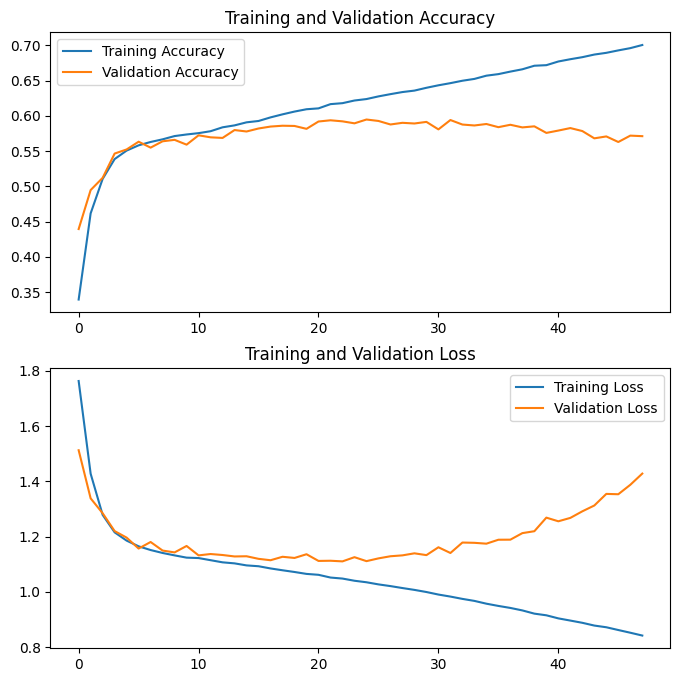

In [5]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_train, plot_snr_to_acc
plot_train(h.history)

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.5706363636363636}
8PSK test accuracy: 0.5451713395638629
AM-DSB test accuracy: 0.6597014925373135
AM-SSB test accuracy: 0.652575315840622
BPSK test accuracy: 0.6364073006724303
CPFSK test accuracy: 0.6156233833419555
GFSK test accuracy: 0.6508172362555721
PAM4 test accuracy: 0.6767830045523521
QAM16 test accuracy: 0.5576635047428856
QAM64 test accuracy: 0.43702960361264426
QPSK test accuracy: 0.548436699128652
WBFM test accuracy: 0.2978515625
Confusion matrix:
[[1050   35  389   89   58   27   21   88   43  103   23]
 [  31 1326  286   45   24   60   12   18    5   15  188]
 [ 106   85 1343  134   86   82   46   42   14   66   54]
 [  48   20  419 1325   40   44   89   30   22   27   18]
 [  70   38  368   66 1190   50   26   45   15   42   23]
 [  22   50  369   65   52 1314   15   27   11   29   65]
 [  37   25  317  120   32   28 1338   35    8   23   14]
 [ 113   23  257   60   45   16   38 1117  252   64   18]
 [ 101   

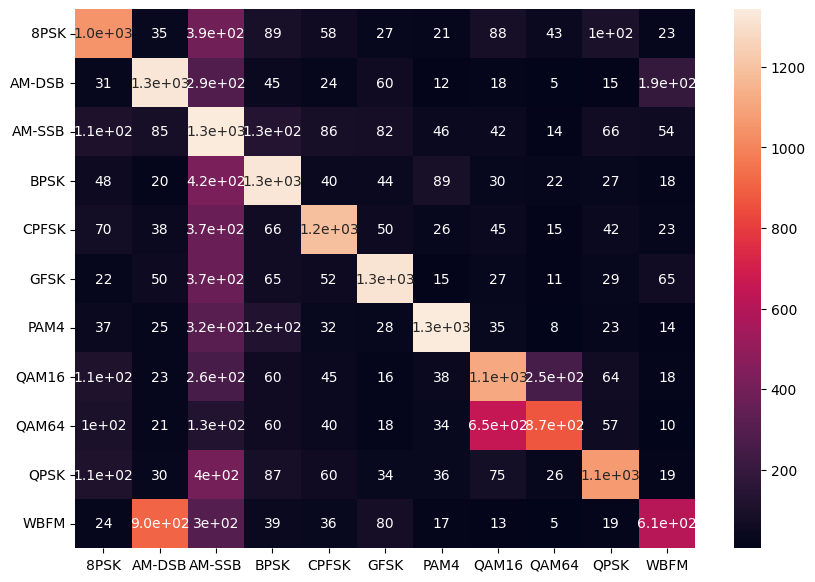

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.5713181818181818}
8PSK test accuracy: 0.5391899000526039
AM-DSB test accuracy: 0.6673407482305359
AM-SSB test accuracy: 0.6585980837115482
BPSK test accuracy: 0.6379310344827587
CPFSK test accuracy: 0.6256062075654704
GFSK test accuracy: 0.6555555555555556
PAM4 test accuracy: 0.6959689169499758
QAM16 test accuracy: 0.5491886409736308
QAM64 test accuracy: 0.41746641074856045
QPSK test accuracy: 0.5486459378134403
WBFM test accuracy: 0.29379652605459056
Confusion matrix:
[[1025   37  410   84   47   36   30   82   40   94   16]
 [  33 1320  283   33   30   55   14   11    6   15  178]
 [  90   78 1306  163   83   67   51   56   11   39   39]
 [  48   20  395 1258   44   35   73   32   13   28   26]
 [  68   44  392   64 1290   53   27   40   17   40   27]
 [  40   64  355   53   38 1298   19   19    9   19   66]
 [  31   28  283  155   28   24 1433   29    7   22   19]
 [ 112   24  223   69   46   37   36 1083  255   73   14]


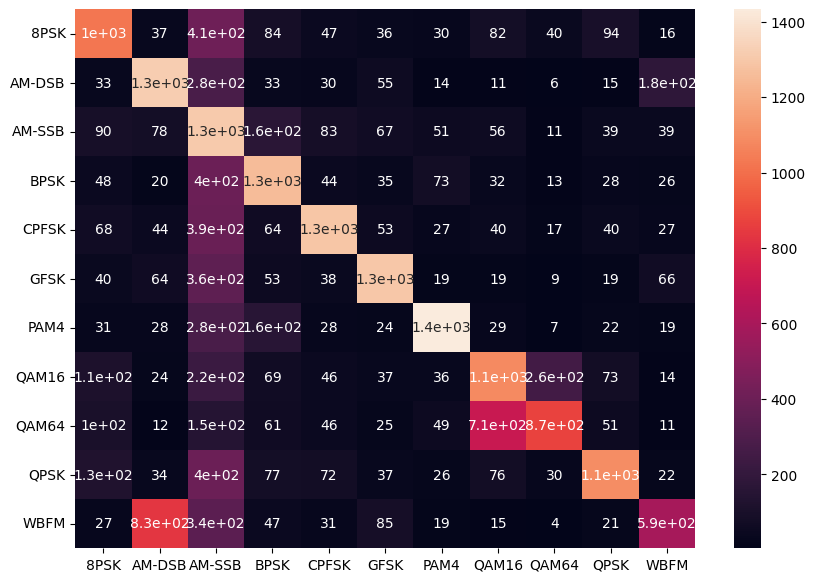

In [6]:
cm_test, cls_to_acc_test = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
)

SNR: -20 -- Overall test accuracy: 0.1106233538191396
SNR: -18 -- Overall test accuracy: 0.08781362007168458
SNR: -16 -- Overall test accuracy: 0.09622641509433963
SNR: -14 -- Overall test accuracy: 0.12307692307692308
SNR: -12 -- Overall test accuracy: 0.14377880184331798
SNR: -10 -- Overall test accuracy: 0.2299168975069252
SNR: -8 -- Overall test accuracy: 0.3336267605633803
SNR: -6 -- Overall test accuracy: 0.4726090993500464
SNR: -4 -- Overall test accuracy: 0.6243339253996447
SNR: -2 -- Overall test accuracy: 0.7323943661971831
SNR: 0 -- Overall test accuracy: 0.8226102941176471
SNR: 2 -- Overall test accuracy: 0.8357664233576643
SNR: 4 -- Overall test accuracy: 0.8493023255813954
SNR: 6 -- Overall test accuracy: 0.8601959038290294
SNR: 8 -- Overall test accuracy: 0.8609332113449222
SNR: 10 -- Overall test accuracy: 0.8626373626373627
SNR: 12 -- Overall test accuracy: 0.8288043478260869
SNR: 14 -- Overall test accuracy: 0.8642413487133984
SNR: 16 -- Overall test accuracy: 0.84011

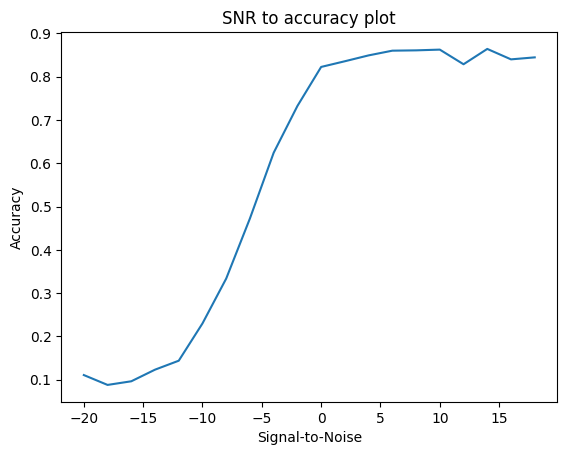

In [7]:
snr_to_acc_test = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)
snr_to_acc_val = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().val],
)
plot_snr_to_acc(snr_to_acc_test)

# Save results

In [10]:
from evaluation.results_serialization import dump_results

from copy import deepcopy

history = deepcopy(h.history)
# history["lr"] = list(map(lambda x: float(x), history["lr"]))

dump_results(
    model_dir, 
    model=model,
    model_config=cnn_v1_configuration,
    model_name=ModelName.CNN_1D_V012,
    dataset_name=DatasetName.RADIOML_2016,
    dataset_path=dataset_path,
    train_history=history,
    cm_test=cm_test,
    cls_to_acc_test=cls_to_acc_test,
    snr_to_acc_test=snr_to_acc_test,
    cm_val=cm_val,
    cls_to_acc_val=cls_to_acc_val,
    snr_to_acc_val=snr_to_acc_val,
    dump_model=True,
)

# TF lite
Convert model to TF lite with/without quantization, and evaluate

1. No quantization

INFO:tensorflow:Assets written to: small_cnn_test_results//model_original/assets


INFO:tensorflow:Assets written to: small_cnn_test_results//model_original/assets
2023-07-31 20:46:44.102200: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-31 20:46:44.102226: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-31 20:46:44.103125: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: small_cnn_test_results//model_original
2023-07-31 20:46:44.106144: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-31 20:46:44.106158: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: small_cnn_test_results//model_original
2023-07-31 20:46:44.113940: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-07-31 20:46:44.116489: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-31 20:46:44.220678

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.570590909090909}
8PSK test accuracy: 0.5451713395638629
AM-DSB test accuracy: 0.6597014925373135
AM-SSB test accuracy: 0.652575315840622
BPSK test accuracy: 0.6364073006724303
CPFSK test accuracy: 0.6156233833419555
GFSK test accuracy: 0.6508172362555721
PAM4 test accuracy: 0.6767830045523521
QAM16 test accuracy: 0.5576635047428856
QAM64 test accuracy: 0.43702960361264426
QPSK test accuracy: 0.548436699128652
WBFM test accuracy: 0.29736328125
Confusion matrix:
[[1050   35  389   89   58   27   21   88   43  103   23]
 [  31 1326  286   45   24   60   12   18    5   15  188]
 [ 106   85 1343  134   86   82   46   42   14   66   54]
 [  48   20  419 1325   40   44   89   30   22   27   18]
 [  70   38  368   66 1190   50   26   45   15   42   23]
 [  22   50  369   65   52 1314   15   27   11   29   65]
 [  38   25  316  120   32   28 1338   35    8   23   14]
 [ 113   23  257   60   45   16   38 1117  252   64   18]
 [ 101   

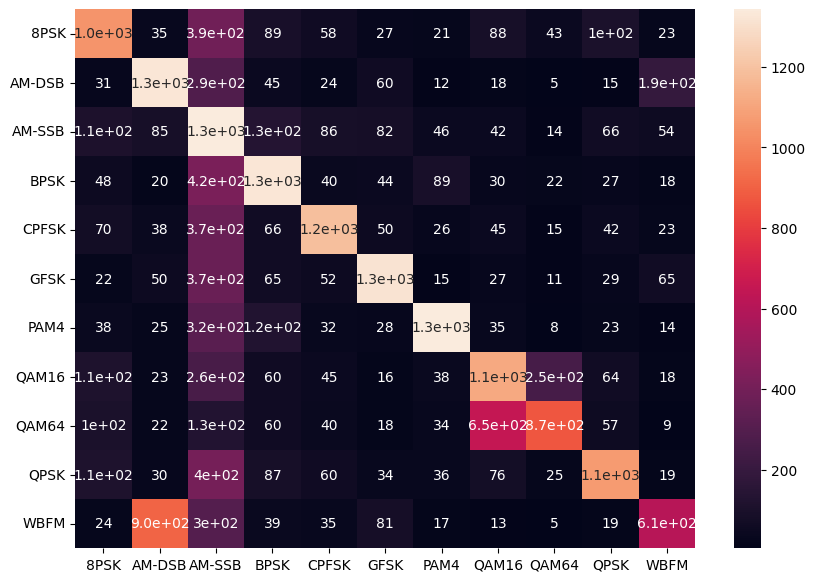

SNR: -20 -- Overall test accuracy: 0.1106233538191396
SNR: -18 -- Overall test accuracy: 0.08781362007168458
SNR: -16 -- Overall test accuracy: 0.09622641509433963
SNR: -14 -- Overall test accuracy: 0.12307692307692308
SNR: -12 -- Overall test accuracy: 0.14377880184331798
SNR: -10 -- Overall test accuracy: 0.2299168975069252
SNR: -8 -- Overall test accuracy: 0.3336267605633803
SNR: -6 -- Overall test accuracy: 0.4726090993500464
SNR: -4 -- Overall test accuracy: 0.6234458259325044
SNR: -2 -- Overall test accuracy: 0.7323943661971831
SNR: 0 -- Overall test accuracy: 0.8226102941176471
SNR: 2 -- Overall test accuracy: 0.8357664233576643
SNR: 4 -- Overall test accuracy: 0.8493023255813954
SNR: 6 -- Overall test accuracy: 0.8601959038290294
SNR: 8 -- Overall test accuracy: 0.8609332113449222
SNR: 10 -- Overall test accuracy: 0.8626373626373627
SNR: 12 -- Overall test accuracy: 0.8288043478260869
SNR: 14 -- Overall test accuracy: 0.8642413487133984
SNR: 16 -- Overall test accuracy: 0.84011

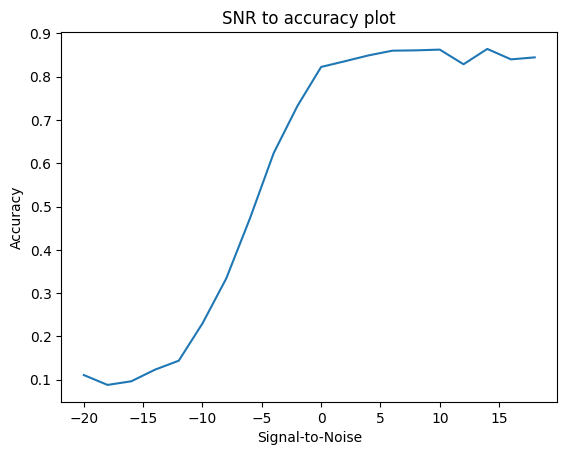

In [13]:
# reload_module("deployment_tools")
# reload_module("evaluation.metric_evaluation")
from deployment_tools import to_tf_lite, predict_tflite
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation

model_path = f"{model_dir}/model_original"
model.save(model_path)

model_tflile_no_quant = to_tf_lite(model_path, apply_quantization=False)

cm_test_tflite_no_quant, cls_to_acc_test_tflite_no_quant = metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite_no_quant = snr_to_metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite_no_quant)

2023-07-31 20:47:20.441370: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-31 20:47:20.441395: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-31 20:47:20.442034: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: small_cnn_test_results//model_original
2023-07-31 20:47:20.444440: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-31 20:47:20.444457: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: small_cnn_test_results//model_original
2023-07-31 20:47:20.451755: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-31 20:47:20.540692: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: small_cnn_test_results//model_original
2023-07-31 20:47:20.559398: I tensorflow/cc/saved_model/loader.cc:314] Sav

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.570590909090909}
8PSK test accuracy: 0.5451713395638629
AM-DSB test accuracy: 0.6597014925373135
AM-SSB test accuracy: 0.652575315840622
BPSK test accuracy: 0.6364073006724303
CPFSK test accuracy: 0.6156233833419555
GFSK test accuracy: 0.6508172362555721
PAM4 test accuracy: 0.6767830045523521
QAM16 test accuracy: 0.5576635047428856
QAM64 test accuracy: 0.43702960361264426
QPSK test accuracy: 0.548436699128652
WBFM test accuracy: 0.29736328125
Confusion matrix:
[[1050   35  389   89   58   27   21   88   43  103   23]
 [  31 1326  286   45   24   60   12   18    5   15  188]
 [ 106   85 1343  134   86   82   46   42   14   66   54]
 [  48   20  419 1325   40   44   89   30   22   27   18]
 [  70   38  368   66 1190   50   26   45   15   42   23]
 [  22   50  369   65   52 1314   15   27   11   29   65]
 [  38   25  316  120   32   28 1338   35    8   23   14]
 [ 113   23  257   60   45   16   38 1117  252   64   18]
 [ 101   

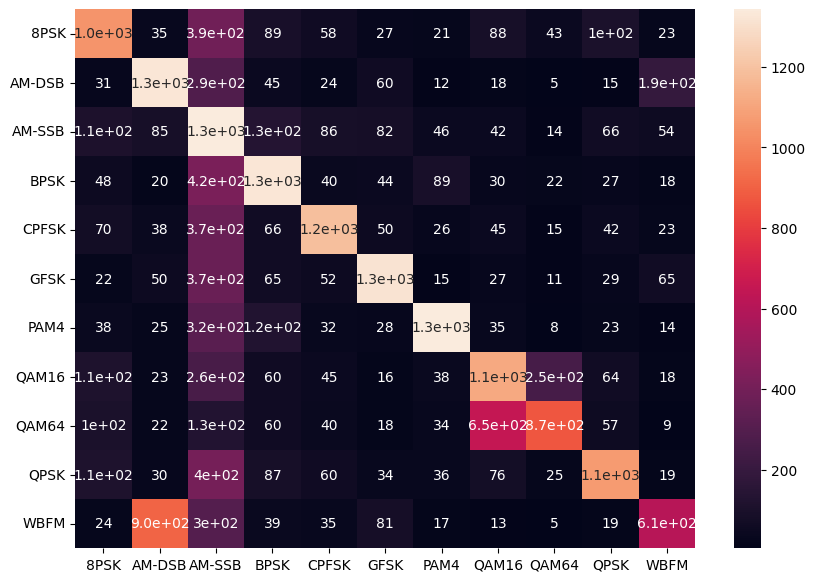

SNR: -20 -- Overall test accuracy: 0.1106233538191396
SNR: -18 -- Overall test accuracy: 0.08781362007168458
SNR: -16 -- Overall test accuracy: 0.09622641509433963
SNR: -14 -- Overall test accuracy: 0.12307692307692308
SNR: -12 -- Overall test accuracy: 0.14377880184331798
SNR: -10 -- Overall test accuracy: 0.2299168975069252
SNR: -8 -- Overall test accuracy: 0.3336267605633803
SNR: -6 -- Overall test accuracy: 0.4726090993500464
SNR: -4 -- Overall test accuracy: 0.6234458259325044
SNR: -2 -- Overall test accuracy: 0.7323943661971831
SNR: 0 -- Overall test accuracy: 0.8226102941176471
SNR: 2 -- Overall test accuracy: 0.8357664233576643
SNR: 4 -- Overall test accuracy: 0.8493023255813954
SNR: 6 -- Overall test accuracy: 0.8601959038290294
SNR: 8 -- Overall test accuracy: 0.8609332113449222
SNR: 10 -- Overall test accuracy: 0.8626373626373627
SNR: 12 -- Overall test accuracy: 0.8288043478260869
SNR: 14 -- Overall test accuracy: 0.8642413487133984
SNR: 16 -- Overall test accuracy: 0.84011

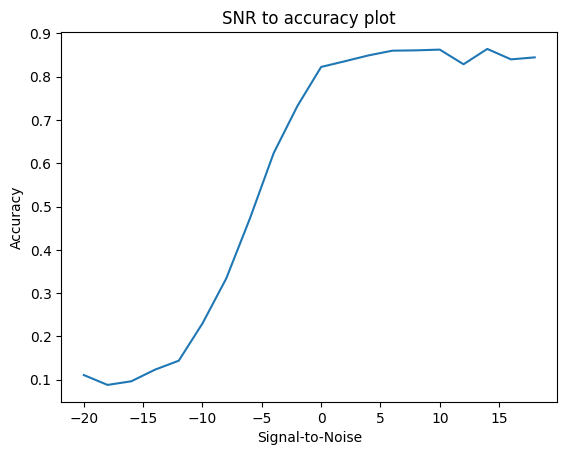

In [14]:
representative_ds = splitted_radioml_ds.train.data[:4000].astype(np.float32)
model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=representative_ds)

cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite = snr_to_metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite)

In [38]:
# reload_module("deployment_tools")
from deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_tflile,
    test_data=splitted_radioml_ds.test.data,
    test_labels=splitted_radioml_ds.test.labels,
    model_name=model_name,
    classes=radioml_ds.get_modulations(),
    epsilon=20,
    apply_quantization=True,
    arena_size=200_000, 
    create_cfu_playground_proj=True
)

[debug] Export test data


11it [00:00, 578.21it/s]
